In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats as scipy_stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from typing import Dict, List, Any 
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import datetime
warnings.filterwarnings('ignore')

# Load CACHE_FILLING datasets
df_cache_filling_mem_available = pd.read_csv("cache filling/mem_available.csv")
df_cache_filling_mem_cache = pd.read_csv("cache filling/mem_cache.csv")
df_cache_filling_mem_util = pd.read_csv("cache filling/mem_util.csv")

# Load GC_STRESS datasets
df_gc_stress_mem_available = pd.read_csv("gc stress/mem_available.csv")
df_gc_stress_mem_cache = pd.read_csv("gc stress/mem_cache.csv")
df_gc_stress_mem_util = pd.read_csv("gc stress/mem_util.csv")

# Load OOM datasets
df_oom_mem_available = pd.read_csv("oom/mem_available.csv")
df_oom_mem_cache = pd.read_csv("oom/mem_cache.csv")
df_oom_mem_util = pd.read_csv("oom/mem_util.csv")

# Load THREADFULL datasets
df_threadfull_mem_available = pd.read_csv("threadfull/mem_available.csv")
df_threadfull_mem_cache = pd.read_csv("threadfull/mem_cache.csv")
df_threadfull_mem_util = pd.read_csv("threadfull/mem_util.csv")

# Add source labels - CACHE_FILLING
df_cache_filling_mem_available["source"] = "cache_filling"
df_cache_filling_mem_cache["source"] = "cache_filling"
df_cache_filling_mem_util["source"] = "cache_filling"

# Add source labels - GC_STRESS
df_gc_stress_mem_available["source"] = "gc_stress"
df_gc_stress_mem_cache["source"] = "gc_stress"
df_gc_stress_mem_util["source"] = "gc_stress"

# Add source labels - OOM
df_oom_mem_available["source"] = "oom"
df_oom_mem_cache["source"] = "oom"
df_oom_mem_util["source"] = "oom"

# Add source labels - THREADFULL
df_threadfull_mem_available["source"] = "threadfull"
df_threadfull_mem_cache["source"] = "threadfull"
df_threadfull_mem_util["source"] = "threadfull"

# Convert to datetime - CACHE_FILLING
df_cache_filling_mem_available["Time"] = pd.to_datetime(df_cache_filling_mem_available["Time"])
df_cache_filling_mem_cache["Time"] = pd.to_datetime(df_cache_filling_mem_cache["Time"])
df_cache_filling_mem_util["Time"] = pd.to_datetime(df_cache_filling_mem_util["Time"])

# Convert to datetime - GC_STRESS
df_gc_stress_mem_available["Time"] = pd.to_datetime(df_gc_stress_mem_available["Time"])
df_gc_stress_mem_cache["Time"] = pd.to_datetime(df_gc_stress_mem_cache["Time"])
df_gc_stress_mem_util["Time"] = pd.to_datetime(df_gc_stress_mem_util["Time"])

# Convert to datetime - OOM
df_oom_mem_available["Time"] = pd.to_datetime(df_oom_mem_available["Time"])
df_oom_mem_cache["Time"] = pd.to_datetime(df_oom_mem_cache["Time"])
df_oom_mem_util["Time"] = pd.to_datetime(df_oom_mem_util["Time"])

# Convert to datetime - THREADFULL
df_threadfull_mem_available["Time"] = pd.to_datetime(df_threadfull_mem_available["Time"])
df_threadfull_mem_cache["Time"] = pd.to_datetime(df_threadfull_mem_cache["Time"])
df_threadfull_mem_util["Time"] = pd.to_datetime(df_threadfull_mem_util["Time"])

delay = 30
duration = 50

# Synchronize all datasets with the first dataset's timeline
# Using cache_filling mem_available as reference
time_offset = df_cache_filling_mem_available["Time"].min()

# Synchronize GC_STRESS datasets
gc_stress_offset = time_offset - df_gc_stress_mem_available["Time"].min()
df_gc_stress_mem_available["Time"] += gc_stress_offset
df_gc_stress_mem_cache["Time"] += gc_stress_offset
df_gc_stress_mem_util["Time"] += gc_stress_offset

# Synchronize OOM datasets
oom_offset = time_offset - df_oom_mem_available["Time"].min()
df_oom_mem_available["Time"] += oom_offset
df_oom_mem_cache["Time"] += oom_offset
df_oom_mem_util["Time"] += oom_offset

# Synchronize THREADFULL datasets
threadfull_offset = time_offset - df_threadfull_mem_available["Time"].min()
df_threadfull_mem_available["Time"] += threadfull_offset
df_threadfull_mem_cache["Time"] += threadfull_offset
df_threadfull_mem_util["Time"] += threadfull_offset

# Convert timeline to minutes for ALL datasets
all_dfs = [
    df_cache_filling_mem_available, df_cache_filling_mem_cache, df_cache_filling_mem_util,
    df_gc_stress_mem_available, df_gc_stress_mem_cache, df_gc_stress_mem_util,
    df_oom_mem_available, df_oom_mem_cache, df_oom_mem_util,
    df_threadfull_mem_available, df_threadfull_mem_cache, df_threadfull_mem_util
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# COMPLETE MEMORY DATASETS DICTIONARY 
all_datasets = {
    'MemAvailable': {
        'cache_filling': df_cache_filling_mem_available,
        'gc_stress': df_gc_stress_mem_available,
        'oom': df_oom_mem_available,
        'threadfull': df_threadfull_mem_available,
    },
    'MemCache': {
        'cache_filling': df_cache_filling_mem_cache,
        'gc_stress': df_gc_stress_mem_cache,
        'oom': df_oom_mem_cache,
        'threadfull': df_threadfull_mem_cache,
    },
    'MemUtil': {
        'cache_filling': df_cache_filling_mem_util,
        'gc_stress': df_gc_stress_mem_util,
        'oom': df_oom_mem_util,
        'threadfull': df_threadfull_mem_util,
    }
}

print("✅ All memory datasets loaded successfully!")
print(f"📊 Loaded {len(all_datasets)} memory metrics across {len(all_datasets['MemAvailable'])} experiment types")
print("\nMemory dataset structure:")
for metric, experiments in all_datasets.items():
    print(f"  {metric}: {list(experiments.keys())}")

# Quick data validation
print("\n🔍 Quick validation:")
for metric_name, experiments in all_datasets.items():
    print(f"\n{metric_name}:")
    for exp_name, df in experiments.items():
        exclude_cols = ['Time', 'Minutes', 'source']
        value_cols = [col for col in df.columns if col not in exclude_cols]
        print(f"  {exp_name}: {len(df)} rows, {len(value_cols)} value columns")
        
        # Check for data variance
        if value_cols:
            cumulative = df[value_cols].sum(axis=1)
            has_variance = np.std(cumulative) > 0 and len(np.unique(cumulative)) > 1
            print(f"    Variance check: {'✅' if has_variance else '❌'}")
            print(f"    Data range: {cumulative.min():.1f} to {cumulative.max():.1f}")

print("\n🚀 Ready for TUNA analysis!")
print("Next steps:")
print("1. Run: tuna_results = run_tuna_for_all_metrics_by_column(all_datasets)")
print("2. Plot: plot_tuna_results(tuna_results, all_datasets)")
print("3. Summary: print_tuna_summary(tuna_results)")

✅ All memory datasets loaded successfully!
📊 Loaded 3 memory metrics across 4 experiment types

Memory dataset structure:
  MemAvailable: ['cache_filling', 'gc_stress', 'oom', 'threadfull']
  MemCache: ['cache_filling', 'gc_stress', 'oom', 'threadfull']
  MemUtil: ['cache_filling', 'gc_stress', 'oom', 'threadfull']

🔍 Quick validation:

MemAvailable:
  cache_filling: 480 rows, 1 value columns
    Variance check: ✅
    Data range: 5756704.0 to 15445808.0
  gc_stress: 481 rows, 1 value columns
    Variance check: ✅
    Data range: 7484896.0 to 16849660.0
  oom: 481 rows, 1 value columns
    Variance check: ✅
    Data range: 7215508.0 to 16636156.0
  threadfull: 481 rows, 1 value columns
    Variance check: ✅
    Data range: 7657632.0 to 16937400.0

MemCache:
  cache_filling: 480 rows, 1 value columns
    Variance check: ✅
    Data range: 4977260.0 to 5076212.0
  gc_stress: 481 rows, 1 value columns
    Variance check: ✅
    Data range: 4981840.0 to 5058440.0
  oom: 481 rows, 1 value colu

🧠 Processing memory metric: MemAvailable
  ✅ cache_filling: Valid for TUNA processing
  ✅ gc_stress: Valid for TUNA processing
  ✅ oom: Valid for TUNA processing
  ✅ threadfull: Valid for TUNA processing
  🤖 Training ML models for MemAvailable...
  🧹 Cleaning MemAvailable - cache_filling (Local Trend + MIN/MAX)
    📊 Outliers: 128, Noise reduction: 2.5%
  🧹 Cleaning MemAvailable - gc_stress (Local Trend + MIN/MAX)
    📊 Outliers: 68, Noise reduction: 2.1%
  🧹 Cleaning MemAvailable - oom (Local Trend + MIN/MAX)
    📊 Outliers: 71, Noise reduction: 3.0%
  🧹 Cleaning MemAvailable - threadfull (Local Trend + MIN/MAX)
    📊 Outliers: 78, Noise reduction: 4.4%
🧠 Processing memory metric: MemCache
  ✅ cache_filling: Valid for TUNA processing
  ✅ gc_stress: Valid for TUNA processing
  ✅ oom: Valid for TUNA processing
  ✅ threadfull: Valid for TUNA processing
  🤖 Training ML models for MemCache...
  🧹 Cleaning MemCache - cache_filling (Local Trend + MIN/MAX)
    📊 Outliers: 0, Noise reduction: 

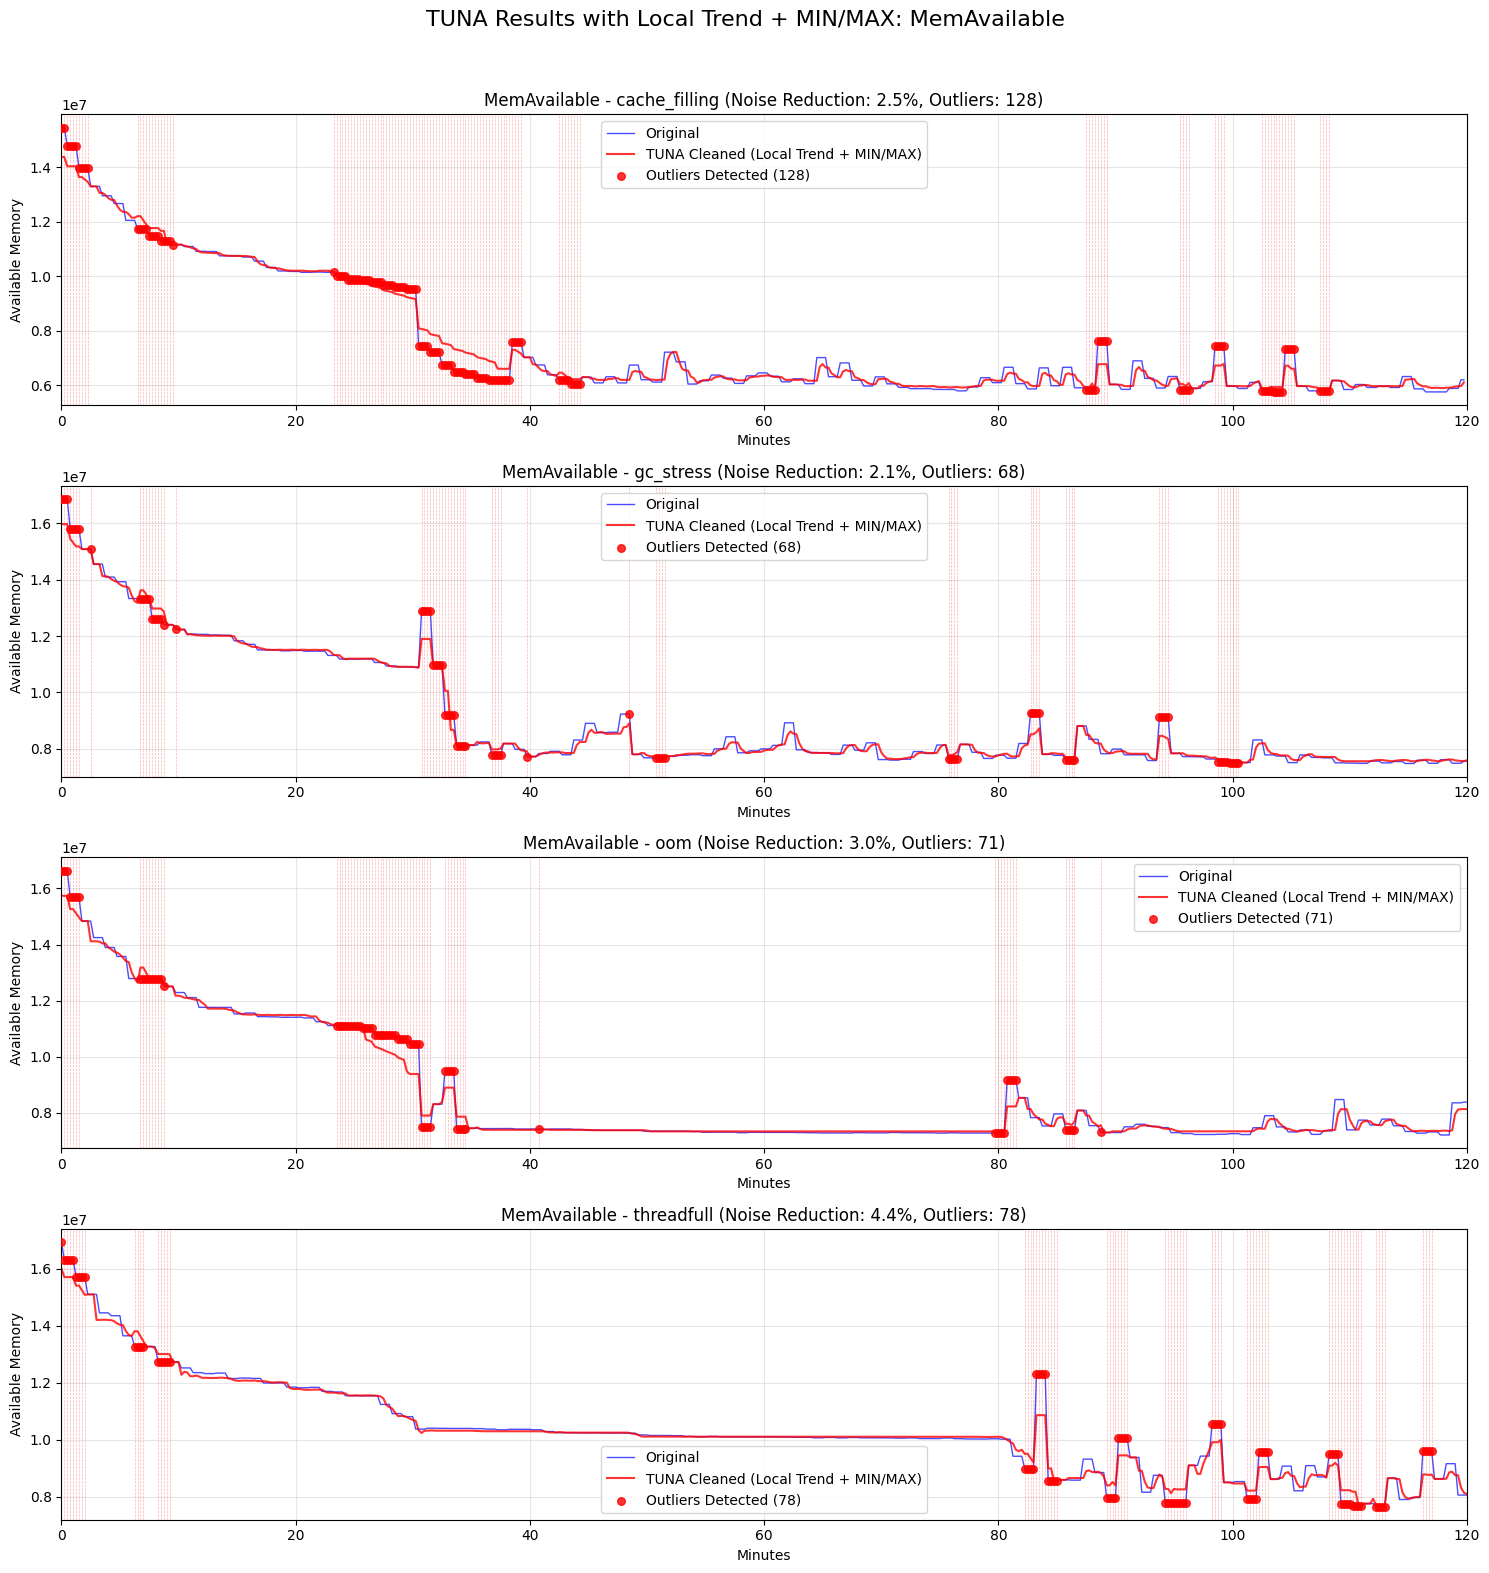

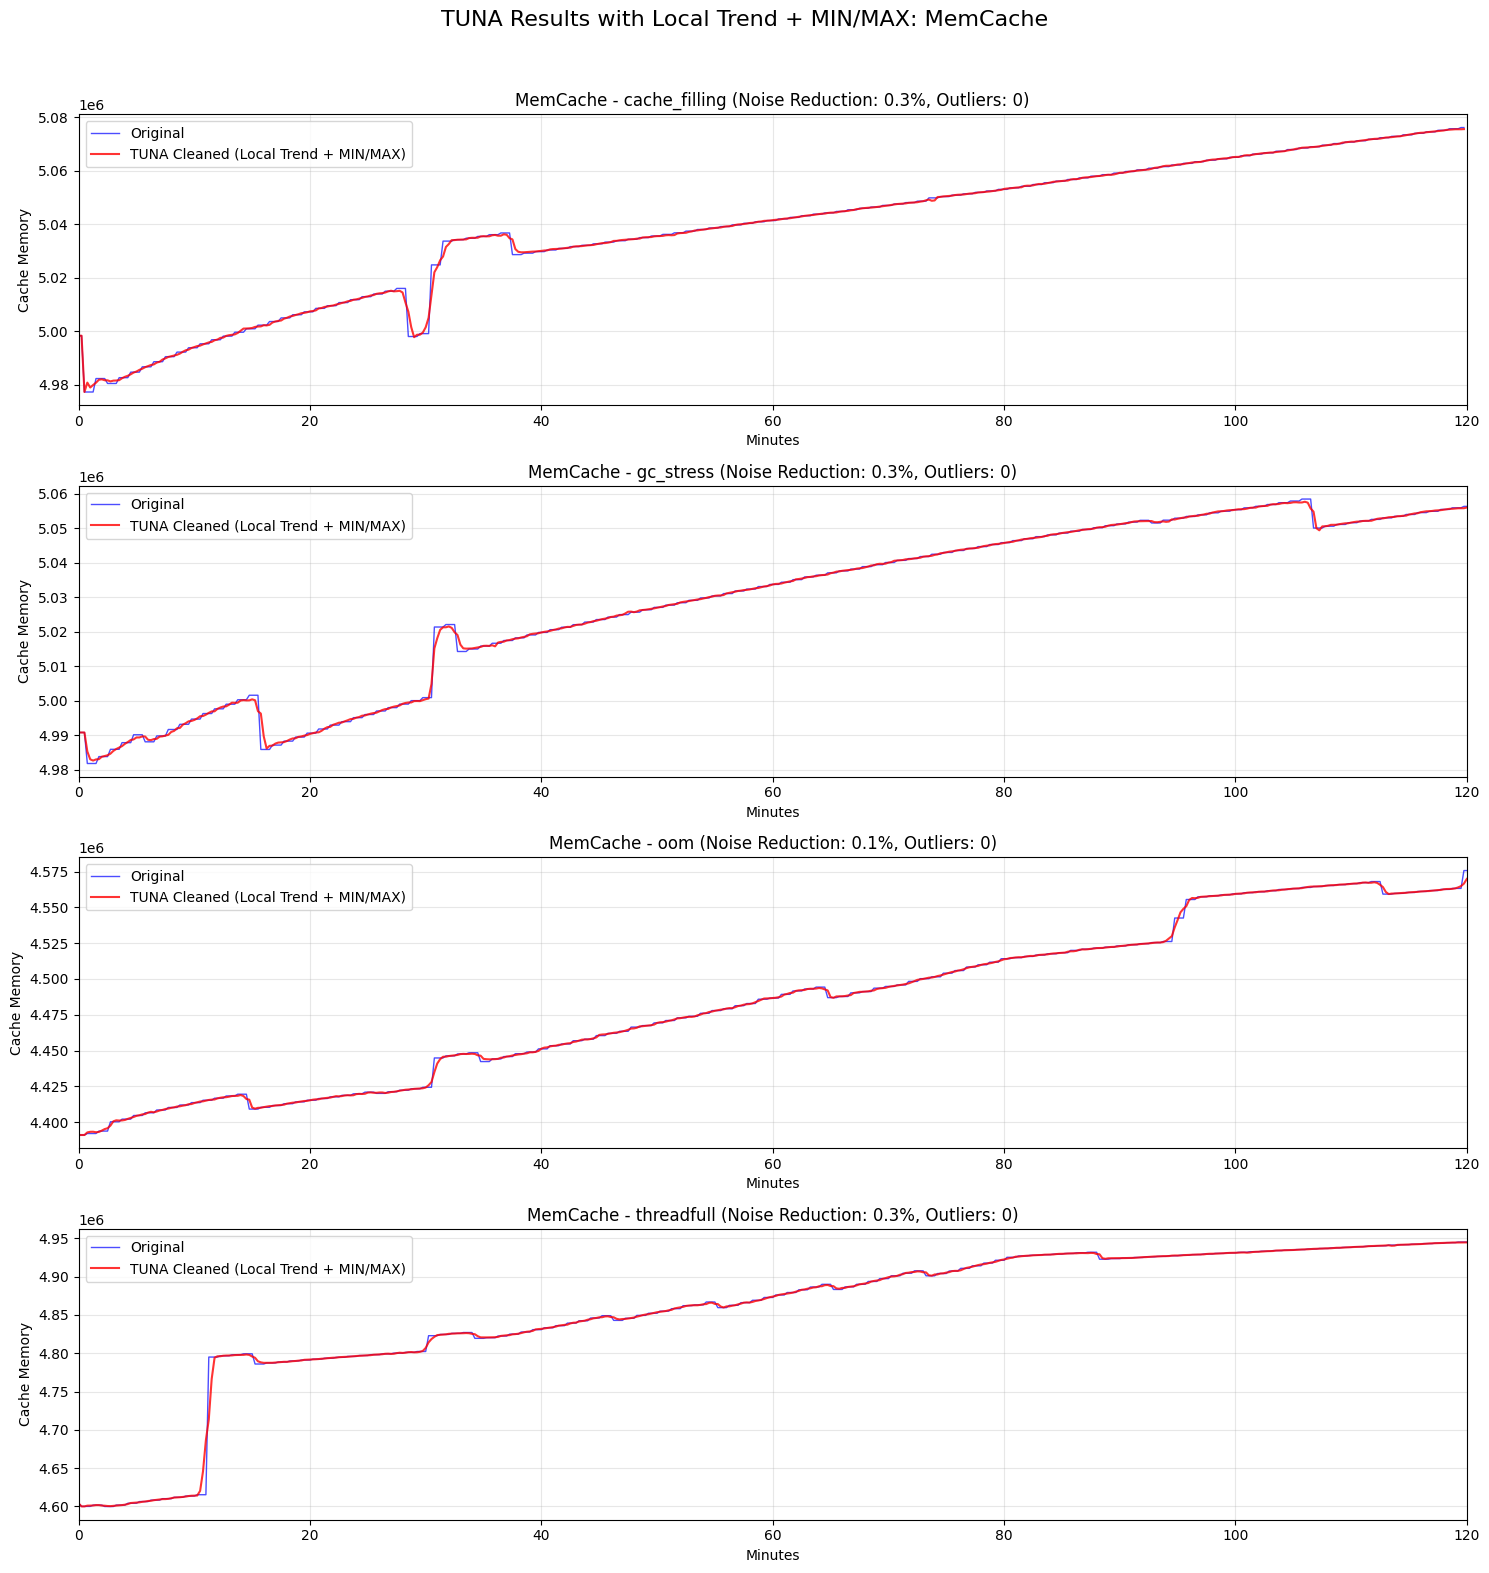

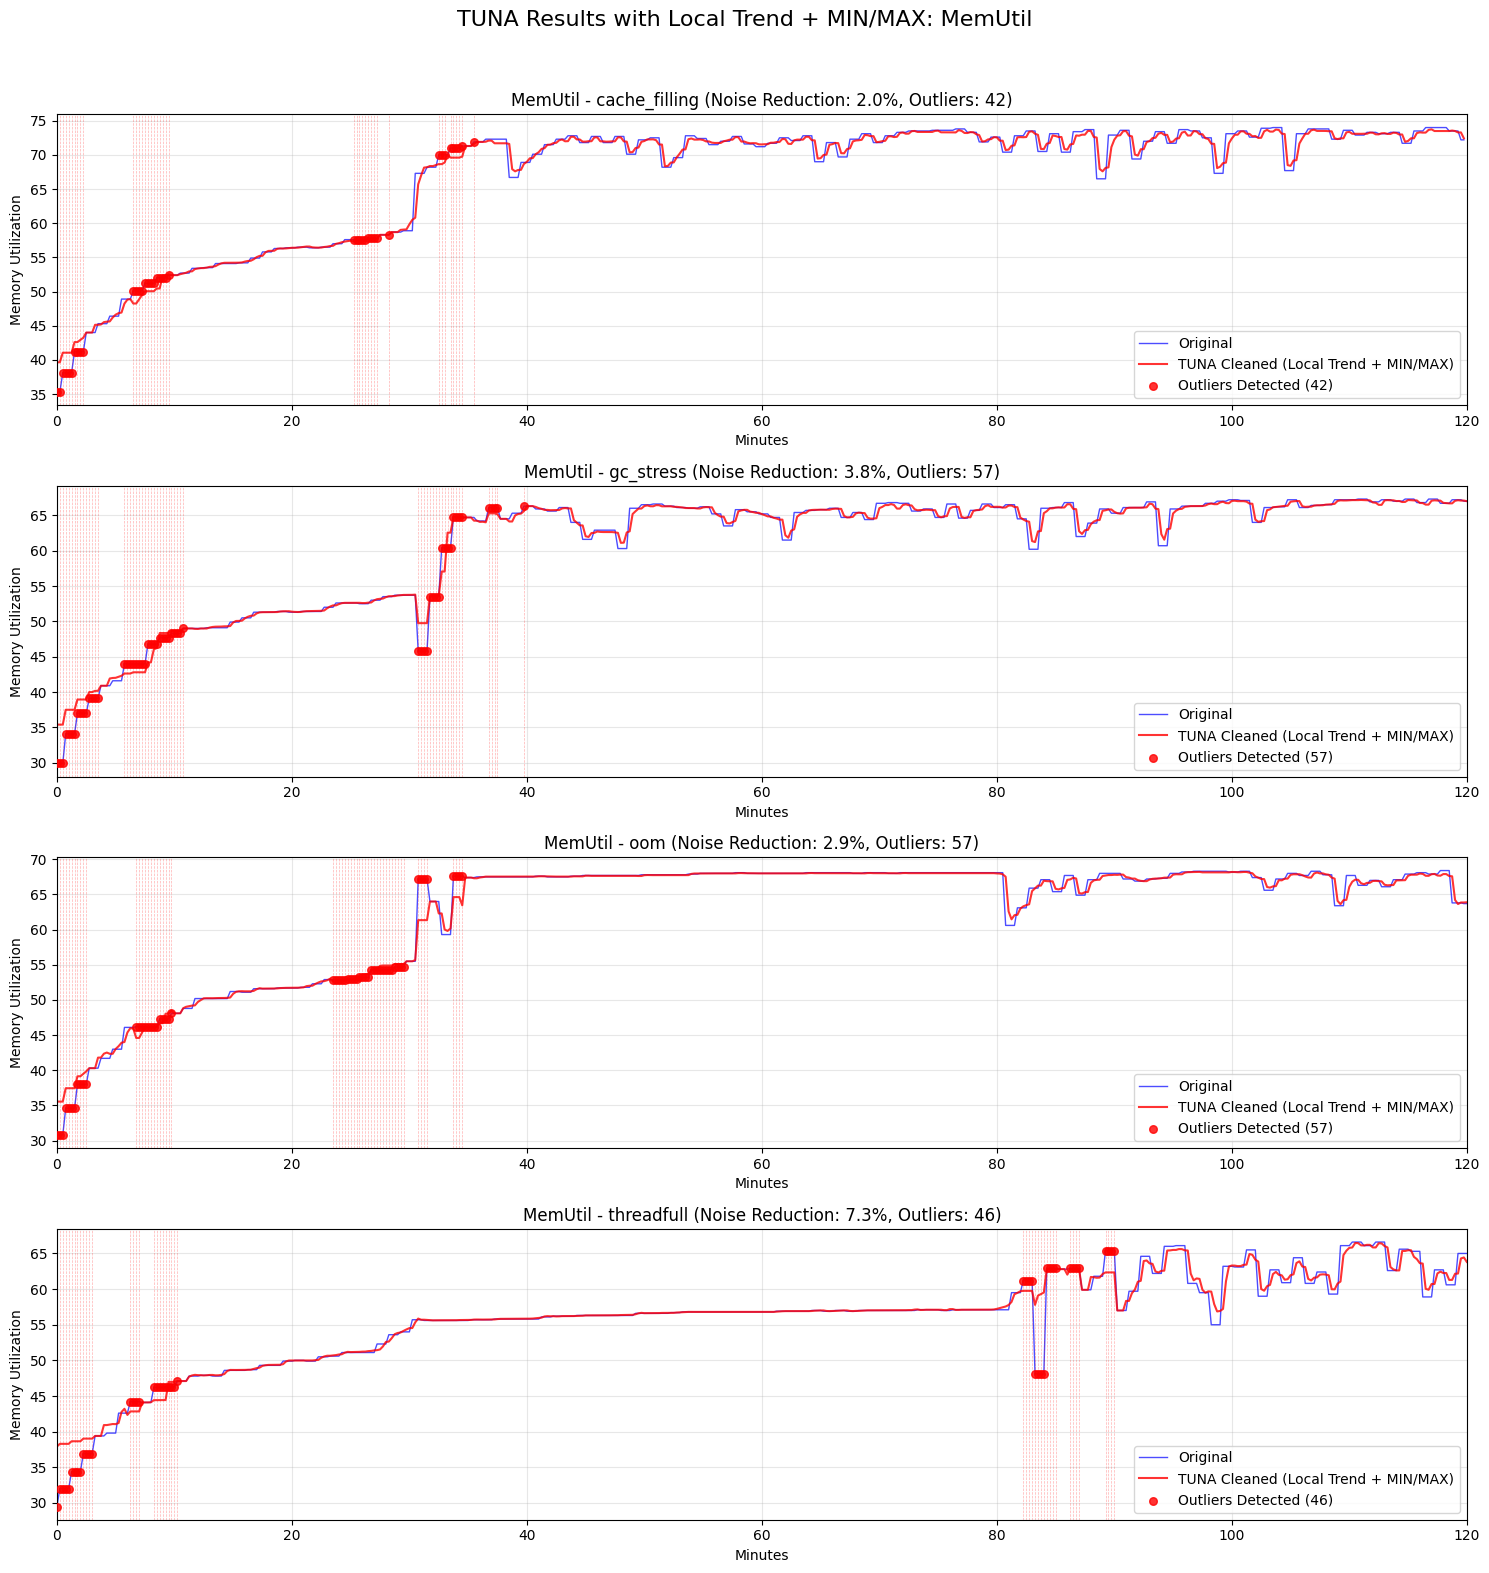


Memory TUNA Results Summary (Local Trend + MIN/MAX Method):
Metric          Experiment      Outliers   Noise Red%   Correlation 
----------------------------------------------------------------------
MemAvailable    cache_filling   128               2.5%       0.992
MemAvailable    gc_stress       68                2.1%       0.995
MemAvailable    oom             71                3.0%       0.994
MemAvailable    threadfull      78                4.4%       0.988
MemCache        cache_filling   0                 0.3%       0.999
MemCache        gc_stress       0                 0.3%       0.999
MemCache        oom             0                 0.1%       1.000
MemCache        threadfull      0                 0.3%       0.998
MemUtil         cache_filling   42                2.0%       0.994
MemUtil         gc_stress       57                3.8%       0.993
MemUtil         oom             57                2.9%       0.994
MemUtil         threadfull      46                7.3%       0

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

def calculate_cumulative_io(df):
    """Calculate total IO from all IO columns"""
    exclude_cols = ['Time', 'Minutes', 'source']
    io_cols = [col for col in df.columns if col not in exclude_cols]
    return df[io_cols].sum(axis=1).values

def detect_outliers_tuna_memory(timeseries, window_size=10, threshold=1.0, min_absolute_range=None, metric_name="", experiment_type=""):
    """
    TUNA's relative range outlier detection with MIN/MAX marking
    Formula: (max - min) / mean > threshold
    """
    outlier_mask = np.zeros(len(timeseries), dtype=bool)
    
    # OPTIMIZED parameters for memory metrics
    if "memcache" in metric_name.lower():
        window_size = 8   # Balanced for cache transitions
        threshold = 0.4   # Sensitive for cache changes
    elif "memavailable" in metric_name.lower():
        window_size = 30   # Larger window for memory spikes
        threshold = 0.20   # Sensitive for memory changes
    elif "memutil" in metric_name.lower():
        window_size = 30   # Larger window for other experiments
        threshold = 0.20  # Moderately sensitive
    else:
        # Default for unknown memory metrics
        window_size = 6
        threshold = 0.2
    
    # More aggressive minimum range for better detection
    if min_absolute_range is None:
        if "memutil" in metric_name.lower() and "threadfull" in str(experiment_type).lower():
            min_absolute_range = 0.01 * np.std(timeseries)  # Very aggressive for threadfull
        else:
            min_absolute_range = 0.05 * np.std(timeseries)  # Aggressive for others
    
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0:
            relative_range = window_range / window_mean
            
            # Apply outlier detection with optimized parameters
            if relative_range > threshold and window_range > min_absolute_range:
                window_max = np.max(window)
                window_min = np.min(window)
                
                # 🎯 KEEP MIN/MAX APPROACH: Mark only min/max values as outliers
                for j in range(window_size):
                    actual_idx = i + j
                    if (timeseries[actual_idx] == window_max or 
                        timeseries[actual_idx] == window_min):
                        outlier_mask[actual_idx] = True
    
    return outlier_mask

def create_features_for_ml_stable_only(timeseries, stable_mask, experiment_type, window_size=3):
    """
    Create features ONLY from stable regions of the timeseries
    """
    features = []
    feature_indices = []
    
    for i in range(window_size, len(timeseries)):
        # Only create features if the current point is stable
        if stable_mask[i]:
            window = timeseries[i-window_size:i]
            window_stable_mask = stable_mask[i-window_size:i]
            
            # Only create features if at least 80% of the window is stable
            stable_ratio = np.sum(window_stable_mask) / len(window_stable_mask)
            if stable_ratio >= 0.8:
                # Use only stable values in the window for feature calculation
                stable_window = window[window_stable_mask]
                
                if len(stable_window) > 0:
                    feature_vector = [
                        np.mean(stable_window),
                        np.std(stable_window),
                        np.median(stable_window),
                        np.max(stable_window) - np.min(stable_window),
                        timeseries[i-1] if stable_mask[i-1] else np.mean(stable_window),
                        i / len(timeseries),
                    ]
                    
                    # Clean any NaN/inf values
                    feature_vector = [0.0 if np.isnan(val) or np.isinf(val) else float(val) for val in feature_vector]
                    
                    # Experiment type encoding
                    exp_features = [0, 0, 0, 0]
                    if experiment_type == "cache_filling":
                        exp_features[0] = 1
                    elif experiment_type == "gc_stress":
                        exp_features[1] = 1
                    elif experiment_type == "oom":
                        exp_features[2] = 1
                    elif experiment_type == "threadfull":
                        exp_features[3] = 1
                    
                    feature_vector.extend(exp_features)
                    features.append(feature_vector)
                    feature_indices.append(i)
    
    return np.array(features), np.array(feature_indices)

def get_local_stable_baseline(timeseries, stable_mask, current_idx, lookback_window):
    """Get local baseline from recent stable points"""
    
    # Strategy 1: Look backwards for recent stable points
    start_idx = max(0, current_idx - lookback_window)
    local_window = timeseries[start_idx:current_idx]
    local_stable_mask = stable_mask[start_idx:current_idx]
    
    recent_stable = local_window[local_stable_mask]
    
    if len(recent_stable) >= 3:
        # Use median of recent stable points
        return np.median(recent_stable)
    elif len(recent_stable) >= 1:
        # Use mean if we have at least one stable point
        return np.mean(recent_stable)
    
    # Strategy 2: If no recent stable points, look forward
    end_idx = min(len(timeseries), current_idx + lookback_window)
    forward_window = timeseries[current_idx+1:end_idx]
    forward_stable_mask = stable_mask[current_idx+1:end_idx]
    
    forward_stable = forward_window[forward_stable_mask]
    
    if len(forward_stable) >= 1:
        return np.median(forward_stable) if len(forward_stable) >= 3 else np.mean(forward_stable)
    
    # Strategy 3: Fallback to interpolation between nearest stable points
    return interpolate_between_stable_points(timeseries, stable_mask, current_idx)

def interpolate_between_stable_points(timeseries, stable_mask, current_idx):
    """Interpolate value based on nearest stable points before and after"""
    
    # Find nearest stable point before
    prev_stable_idx = None
    for i in range(current_idx - 1, -1, -1):
        if stable_mask[i]:
            prev_stable_idx = i
            break
    
    # Find nearest stable point after
    next_stable_idx = None
    for i in range(current_idx + 1, len(timeseries)):
        if stable_mask[i]:
            next_stable_idx = i
            break
    
    if prev_stable_idx is not None and next_stable_idx is not None:
        # Linear interpolation between stable points
        prev_value = timeseries[prev_stable_idx]
        next_value = timeseries[next_stable_idx]
        distance_ratio = (current_idx - prev_stable_idx) / (next_stable_idx - prev_stable_idx)
        return prev_value + (next_value - prev_value) * distance_ratio
    elif prev_stable_idx is not None:
        return timeseries[prev_stable_idx]
    elif next_stable_idx is not None:
        return timeseries[next_stable_idx]
    else:
        # Ultimate fallback - use global median
        stable_values = timeseries[stable_mask]
        return np.median(stable_values) if len(stable_values) > 0 else np.median(timeseries)

def apply_penalty_local_trend(timeseries, outlier_mask, penalty_factor=0.5, metric_name="", experiment_type="", lookback_window=10):
    """Apply penalty based on local stable trend rather than global baseline"""
    cleaned_series = timeseries.copy()
    stable_mask = ~outlier_mask
    
    # Adjust penalty factor based on metric and experiment
    if "memutil" in metric_name.lower() and "threadfull" in str(experiment_type).lower():
        effective_penalty = 0.15
        lookback_window = 5  # Shorter lookback for threadfull
    else:
        effective_penalty = penalty_factor
        lookback_window = min(lookback_window, 15)  # Cap the lookback window
    
    outliers_processed = 0
    
    for i in range(len(timeseries)):
        if outlier_mask[i]:
            # Find local stable baseline by looking at recent stable points
            local_baseline = get_local_stable_baseline(
                timeseries, stable_mask, i, lookback_window
            )
            
            original_value = timeseries[i]
            deviation = original_value - local_baseline
            
            # Apply penalty by reducing deviation from local trend
            cleaned_series[i] = local_baseline + deviation * effective_penalty
            outliers_processed += 1
    
    return cleaned_series, outliers_processed

def apply_tuna_to_single_series_memory_debug(cumulative, exp_name, model, scaler, penalty_factor=0.5, blend_weight=1, metric_name=""):
    """Apply TUNA cleaning with detailed debugging for memory metrics"""
    
    print(f"\n🔍 Processing {metric_name} - {exp_name}")
    print(f"  Data range: {cumulative.min():.2f} to {cumulative.max():.2f}")
    print(f"  Data std: {cumulative.std():.3f}")
    
    # Phase 1: Identify unstable measurements with debugging
    outlier_mask = detect_outliers_tuna_memory(cumulative, metric_name=metric_name, experiment_type=exp_name)
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    print(f"  Outliers detected: {outliers_count}/{len(cumulative)} ({(outliers_count/len(cumulative))*100:.1f}%)")
    
    if outliers_count == 0:
        print("  ⚠️ NO OUTLIERS DETECTED - No penalty will be applied!")
        print("  This explains why the cleaned line matches the original")
    
    # Phase 2: Apply penalty with debugging
    cleaned_series = cumulative.copy()
    outliers_processed = 0
    
    if outliers_count > 0:
        cleaned_series, outliers_processed = apply_penalty_local_trend(
            cumulative, outlier_mask, penalty_factor, metric_name, exp_name
        )
        
        # Calculate actual changes made
        penalty_diff = np.mean(np.abs(cumulative - cleaned_series))
        max_change = np.max(np.abs(cumulative - cleaned_series))
        
        print(f"  Penalty applied to: {outliers_processed} points")
        print(f"  Average change: {penalty_diff:.4f}")
        print(f"  Max change: {max_change:.4f}")
    else:
        print("  No penalty applied (no outliers detected)")
    
    # Phase 3: ML enhancement
    WINDOW_SIZE = 3
    ml_applied = 0
    if model is not None and scaler is not None:
        features, feature_indices = create_features_for_ml_stable_only(
            cumulative, stable_mask, exp_name, window_size=WINDOW_SIZE
        )
        
        if len(features) > 0:
            features_scaled = scaler.transform(features)
            ml_predictions = model.predict(features_scaled)
            
            for i, prediction in enumerate(ml_predictions):
                actual_idx = feature_indices[i]
                if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                    if not np.isnan(prediction) and not np.isinf(prediction):
                        original_value = cumulative[actual_idx]
                        cleaned_series[actual_idx] = (
                            blend_weight * prediction + 
                            (1 - blend_weight) * original_value
                        )
                        ml_applied += 1
        
        print(f"  ML predictions applied: {ml_applied} points")
    
    # Calculate final statistics
    original_std = np.std(cumulative)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100
    correlation = np.corrcoef(cumulative, cleaned_series)[0, 1]
    
    print(f"  Final noise reduction: {noise_reduction:.1f}%")
    print(f"  Final correlation: {correlation:.3f}")
    
    return cleaned_series, outlier_mask, {
        'outliers': outliers_count,
        'noise_reduction': noise_reduction,
        'correlation': correlation
    }

def apply_tuna_to_single_series_memory_local_trend(cumulative, exp_name, model, scaler, penalty_factor=0.5, blend_weight=1, metric_name=""):
    """Apply TUNA cleaning with local trend-based penalty (production version)"""
    
    # Phase 1: Identify unstable measurements
    outlier_mask = detect_outliers_tuna_memory(cumulative, metric_name=metric_name, experiment_type=exp_name)
    stable_mask = ~outlier_mask
    outliers_count = np.sum(outlier_mask)
    
    # Phase 2: Apply local trend-based penalty
    cleaned_series = cumulative.copy()
    
    if outliers_count > 0:
        cleaned_series, _ = apply_penalty_local_trend(
            cumulative, outlier_mask, penalty_factor, metric_name, exp_name
        )
    
    # Phase 3: ML enhancement
    WINDOW_SIZE = 3
    if model is not None and scaler is not None:
        features, feature_indices = create_features_for_ml_stable_only(
            cumulative, stable_mask, exp_name, window_size=WINDOW_SIZE
        )
        
        if len(features) > 0:
            features_scaled = scaler.transform(features)
            ml_predictions = model.predict(features_scaled)
            
            for i, prediction in enumerate(ml_predictions):
                actual_idx = feature_indices[i]
                if actual_idx < len(cleaned_series) and stable_mask[actual_idx]:
                    if not np.isnan(prediction) and not np.isinf(prediction):
                        original_value = cumulative[actual_idx]
                        cleaned_series[actual_idx] = (
                            blend_weight * prediction + 
                            (1 - blend_weight) * original_value
                        )
    
    # Calculate statistics
    original_std = np.std(cumulative)
    cleaned_std = np.std(cleaned_series)
    noise_reduction = (original_std - cleaned_std) / original_std * 100
    correlation = np.corrcoef(cumulative, cleaned_series)[0, 1]
    
    return cleaned_series, outlier_mask, {
        'outliers': outliers_count,
        'noise_reduction': noise_reduction,
        'correlation': correlation
    }

def apply_tuna_to_each_column_memory_local_trend(df, exp_name, models, scalers, penalty_factor=0.5, blend_weight=1, metric_name=""):
    """Apply TUNA cleaning with local trend penalty to each column individually"""
    
    exclude_cols = ['Time', 'Minutes', 'source']
    value_cols = [col for col in df.columns if col not in exclude_cols]
    
    column_results = {}
    cleaned_df = df.copy()
    
    for col in value_cols:
        col_values = df[col].values
        model = models.get(col)
        scaler = scalers.get(col)
        
        cleaned_values, outlier_mask, stats = apply_tuna_to_single_series_memory_local_trend(
            col_values, exp_name, model, scaler, penalty_factor, blend_weight, metric_name
        )
        
        column_results[col] = {
            'original': col_values,
            'cleaned': cleaned_values,
            'outliers': outlier_mask,
            'stats': stats
        }
        
        cleaned_df[col] = cleaned_values
    
    return cleaned_df, column_results

def train_models_for_all_columns_memory(metric_name, all_experiments):
    """Train separate RandomForest models for each column using ONLY stable periods for memory metrics"""
    
    exclude_cols = ['Time', 'Minutes', 'source']
    first_df = list(all_experiments.values())[0]
    value_cols = [col for col in first_df.columns if col not in exclude_cols]
    
    models = {}
    scalers = {}
    
    WINDOW_SIZE = 3
    
    for col in value_cols:
        X_stable_all = []
        y_stable_all = []
        
        for exp_name, df in all_experiments.items():
            col_values = df[col].values
            outlier_mask = detect_outliers_tuna_memory(col_values, window_size=WINDOW_SIZE, metric_name=metric_name, experiment_type=exp_name)
            stable_mask = ~outlier_mask
            
            features, feature_indices = create_features_for_ml_stable_only(
                col_values, stable_mask, exp_name, window_size=WINDOW_SIZE
            )
            
            if len(features) > 0:
                stable_targets = col_values[feature_indices]
                
                valid_mask = ~(np.isnan(stable_targets) | np.isinf(stable_targets))
                stable_features = features[valid_mask]
                stable_targets = stable_targets[valid_mask]
                
                if len(stable_features) > 0:
                    smoothed_targets = []
                    for j, target in enumerate(stable_targets):
                        start_idx = max(0, j-2)
                        end_idx = min(len(stable_targets), j+3)
                        local_values = stable_targets[start_idx:end_idx]
                        smoothed_targets.append(np.median(local_values))
                    
                    X_stable_all.extend(stable_features)
                    y_stable_all.extend(smoothed_targets)
        
        if len(X_stable_all) >= 10:
            X_stable_all = np.array(X_stable_all)
            y_stable_all = np.array(y_stable_all)
            
            nan_mask = np.isnan(y_stable_all) | np.isinf(y_stable_all)
            if np.any(nan_mask):
                X_stable_all = X_stable_all[~nan_mask]
                y_stable_all = y_stable_all[~nan_mask]
            
            feature_nan_mask = np.isnan(X_stable_all).any(axis=1) | np.isinf(X_stable_all).any(axis=1)
            if np.any(feature_nan_mask):
                X_stable_all = X_stable_all[~feature_nan_mask]
                y_stable_all = y_stable_all[~feature_nan_mask]
            
            if len(X_stable_all) >= 10:
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_stable_all)
                
                param_grid = {
                    'n_estimators': [100],
                    'max_depth': [5, 10, 15],
                    'min_samples_split': [2, 5],
                    'min_samples_leaf': [1, 2, 4],
                    'max_features': ['sqrt', 'log2']
                }
                
                model = RandomForestRegressor(
                    criterion='squared_error',
                    bootstrap=True,
                    n_jobs=-1,
                    random_state=42
                )
                
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=3,
                    n_jobs=-1,
                    verbose=0
                )
                
                grid_search.fit(X_scaled, y_stable_all)
                
                models[col] = grid_search.best_estimator_
                scalers[col] = scaler
            else:
                models[col] = None
                scalers[col] = None
        else:
            models[col] = None
            scalers[col] = None
    
    return models, scalers

def run_tuna_for_memory_metrics_local_trend_debug(all_datasets):
    """Run TUNA for memory metrics with detailed debugging"""    
    tuna_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"\n🧠 Processing memory metric: {metric_name}")
        print("="*50)
        
        # Check each experiment for variance BEFORE training
        valid_experiments = {}
        for exp_name, df in experiments.items():
            exclude_cols = ['Time', 'Minutes', 'source']
            value_cols = [col for col in df.columns if col not in exclude_cols]
            cumulative_values = df[value_cols].sum(axis=1).values
            
            # Check for variance in this specific experiment
            has_variance = (np.std(cumulative_values) > 0 and 
                          len(np.unique(cumulative_values)) > 1)
            
            if has_variance:
                valid_experiments[exp_name] = df
                print(f"  ✅ {exp_name}: Valid for TUNA processing")
            else:
                print(f"  ⏭️ {exp_name}: Skipping (no variance)")
        
        # Only train models if we have valid experiments
        if not valid_experiments:
            print(f"  ⏭️ No valid experiments for {metric_name} - skipping training")
            continue
            
        # Train models only on valid experiments
        print(f"\n  🤖 Training ML models for {metric_name}...")
        models, scalers = train_models_for_all_columns_memory(metric_name, valid_experiments)
        
        metric_results = {}
        for exp_name, df in experiments.items():
            if exp_name in valid_experiments:
                # Apply TUNA cleaning with debugging
                exclude_cols = ['Time', 'Minutes', 'source']
                value_cols = [col for col in df.columns if col not in exclude_cols]
                cumulative_values = df[value_cols].sum(axis=1).values
                
                # Debug single series first
                _, _, debug_stats = apply_tuna_to_single_series_memory_debug(
                    cumulative_values, exp_name, None, None, 0.5, 1, metric_name
                )
                
                # Apply to all columns
                cleaned_df, column_results = apply_tuna_to_each_column_memory_local_trend(
                    df, exp_name, models, scalers, metric_name=metric_name
                )
                
                total_outliers = sum(result['stats']['outliers'] for result in column_results.values())
                
                original_cumulative = df[value_cols].sum(axis=1).values
                cleaned_cumulative = cleaned_df[value_cols].sum(axis=1).values
                
                original_std = np.std(original_cumulative)
                cleaned_std = np.std(cleaned_cumulative)
                noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
                correlation = np.corrcoef(original_cumulative, cleaned_cumulative)[0, 1]
                
                overall_outlier_mask = np.zeros(len(df), dtype=bool)
                for col_result in column_results.values():
                    overall_outlier_mask |= col_result['outliers']
                
                metric_results[exp_name] = {
                    'original': original_cumulative,
                    'cleaned': cleaned_cumulative,
                    'outliers': overall_outlier_mask,
                    'stats': {
                        'outliers': total_outliers,
                        'noise_reduction': noise_reduction,
                        'correlation': correlation
                    },
                    'column_results': column_results,
                    'cleaned_df': cleaned_df
                }
                
                print(f"\n  📊 Final Results - {exp_name}:")
                print(f"    Total outliers: {total_outliers}")
                print(f"    Noise reduction: {noise_reduction:.1f}%")
                print(f"    Correlation: {correlation:.3f}")
        
        # Only add to results if we have at least one experiment processed
        if metric_results:
            tuna_results[metric_name] = metric_results
    
    return tuna_results

def run_tuna_for_memory_metrics_local_trend(all_datasets):
    """Run TUNA for memory metrics with local trend-based penalty (production version)"""    
    tuna_results = {}
    
    for metric_name, experiments in all_datasets.items():
        print(f"🧠 Processing memory metric: {metric_name}")
        
        # Check each experiment for variance BEFORE training
        valid_experiments = {}
        for exp_name, df in experiments.items():
            exclude_cols = ['Time', 'Minutes', 'source']
            value_cols = [col for col in df.columns if col not in exclude_cols]
            cumulative_values = df[value_cols].sum(axis=1).values
            
            # Check for variance in this specific experiment
            has_variance = (np.std(cumulative_values) > 0 and 
                          len(np.unique(cumulative_values)) > 1)
            
            if has_variance:
                valid_experiments[exp_name] = df
                print(f"  ✅ {exp_name}: Valid for TUNA processing")
            else:
                print(f"  ⏭️ {exp_name}: Skipping (no variance)")
        
        # Only train models if we have valid experiments
        if not valid_experiments:
            print(f"  ⏭️ No valid experiments for {metric_name} - skipping training")
            continue
            
        # Train models only on valid experiments
        print(f"  🤖 Training ML models for {metric_name}...")
        models, scalers = train_models_for_all_columns_memory(metric_name, valid_experiments)
        
        metric_results = {}
        for exp_name, df in experiments.items():
            if exp_name in valid_experiments:
                # Apply TUNA cleaning with local trend
                print(f"  🧹 Cleaning {metric_name} - {exp_name} (Local Trend + MIN/MAX)")
                cleaned_df, column_results = apply_tuna_to_each_column_memory_local_trend(
                    df, exp_name, models, scalers, metric_name=metric_name
                )
                
                total_outliers = sum(result['stats']['outliers'] for result in column_results.values())
                
                exclude_cols = ['Time', 'Minutes', 'source']
                value_cols = [col for col in df.columns if col not in exclude_cols]
                
                original_cumulative = df[value_cols].sum(axis=1).values
                cleaned_cumulative = cleaned_df[value_cols].sum(axis=1).values
                
                original_std = np.std(original_cumulative)
                cleaned_std = np.std(cleaned_cumulative)
                noise_reduction = (original_std - cleaned_std) / original_std * 100 if original_std > 0 else 0
                correlation = np.corrcoef(original_cumulative, cleaned_cumulative)[0, 1]
                
                overall_outlier_mask = np.zeros(len(df), dtype=bool)
                for col_result in column_results.values():
                    overall_outlier_mask |= col_result['outliers']
                
                metric_results[exp_name] = {
                    'original': original_cumulative,
                    'cleaned': cleaned_cumulative,
                    'outliers': overall_outlier_mask,
                    'stats': {
                        'outliers': total_outliers,
                        'noise_reduction': noise_reduction,
                        'correlation': correlation
                    },
                    'column_results': column_results,
                    'cleaned_df': cleaned_df
                }
                
                print(f"    📊 Outliers: {total_outliers}, Noise reduction: {noise_reduction:.1f}%")
            else:
                # Create dummy results with original data unchanged for invalid experiments
                exclude_cols = ['Time', 'Minutes', 'source']
                value_cols = [col for col in df.columns if col not in exclude_cols]
                cumulative_values = df[value_cols].sum(axis=1).values
                
                metric_results[exp_name] = {
                    'original': cumulative_values,
                    'cleaned': cumulative_values,  # No cleaning applied
                    'outliers': np.zeros(len(df), dtype=bool),
                    'stats': {
                        'outliers': 0,
                        'noise_reduction': 0.0,
                        'correlation': 1.0
                    },
                    'column_results': {},
                    'cleaned_df': df.copy()
                }
        
        # Only add to results if we have at least one experiment processed
        if metric_results:
            tuna_results[metric_name] = metric_results
    
    return tuna_results

def plot_memory_tuna_results_local_trend(tuna_results, all_datasets):
    """Plot TUNA results for memory metrics with local trend method and outlier indicators"""
    
    for metric_name, metric_results in tuna_results.items():
        n_experiments = len(metric_results)
        fig, axes = plt.subplots(n_experiments, 1, figsize=(15, 4*n_experiments))
        
        if n_experiments == 1:
            axes = [axes]
        
        for i, (exp_name, results) in enumerate(metric_results.items()):
            original = results['original']
            cleaned = results['cleaned']
            outliers = results['outliers']
            stats = results['stats']
            
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            
            # Plot original and cleaned data
            axes[i].plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            axes[i].plot(minutes, cleaned, 'r-', alpha=0.8, label='TUNA Cleaned (Local Trend + MIN/MAX)', linewidth=1.5)
            
            # 🎯 HIGHLIGHT OUTLIERS: Mark detected outliers with red dots
            if np.any(outliers):
                outlier_minutes = minutes[outliers]
                outlier_original_values = original[outliers]
                axes[i].scatter(outlier_minutes, outlier_original_values, 
                              color='red', s=30, alpha=0.8, marker='o', 
                              label=f'Outliers Detected ({np.sum(outliers)})', zorder=5)
                
                # Add vertical lines to show outlier positions more clearly
                for outlier_min in outlier_minutes:
                    axes[i].axvline(x=outlier_min, color='red', alpha=0.3, 
                                  linestyle='--', linewidth=0.5)
            
            # Memory-specific labels
            if 'available' in metric_name.lower():
                y_label = 'Available Memory'
            elif 'cache' in metric_name.lower():
                y_label = 'Cache Memory'
            elif 'util' in metric_name.lower():
                y_label = 'Memory Utilization'
            else:
                y_label = 'Memory Values'
            
            axes[i].set_title(f'{metric_name} - {exp_name} (Noise Reduction: {stats["noise_reduction"]:.1f}%, Outliers: {stats["outliers"]})')
            axes[i].set_xlabel('Minutes')
            axes[i].set_ylabel(y_label)
            axes[i].set_xlim(0, 120)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'TUNA Results with Local Trend + MIN/MAX: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def plot_comprehensive_outlier_analysis(tuna_results, all_datasets):
    """Create comprehensive outlier analysis plots for all metrics and experiments"""
    
    print("🎯 Creating comprehensive outlier analysis for all experiments...")
    
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            print(f"\n📊 Analyzing {metric_name} - {exp_name}")
            
            # Get data
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            original = results['original']
            outliers = results['outliers']
            
            # Create detailed outlier analysis plot
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
            
            # Top plot: Original data with outliers
            ax1.plot(minutes, original, 'b-', alpha=0.7, label='Original Data', linewidth=1)
            
            if np.any(outliers):
                outlier_minutes = minutes[outliers]
                outlier_values = original[outliers]
                ax1.scatter(outlier_minutes, outlier_values, color='red', s=40, alpha=0.8, 
                           marker='o', label=f'MIN/MAX Outliers ({np.sum(outliers)})', zorder=5)
                
                # Add vertical lines for outliers
                for outlier_min in outlier_minutes:
                    ax1.axvline(x=outlier_min, color='red', alpha=0.2, linestyle='--', linewidth=0.5)
            
            ax1.set_title(f'{metric_name} - {exp_name}: Outlier Detection (MIN/MAX Strategy)')
            ax1.set_ylabel('Values')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Middle plot: Before vs After cleaning
            ax2.plot(minutes, original, 'b-', alpha=0.7, label='Original', linewidth=1)
            ax2.plot(minutes, results['cleaned'], 'r-', alpha=0.8, 
                    label=f'TUNA Cleaned (Noise Reduction: {results["stats"]["noise_reduction"]:.1f}%)', linewidth=1.5)
            
            # Highlight correction areas
            if np.any(outliers):
                correction_diff = np.abs(original - results['cleaned'])
                significant_corrections = correction_diff > (0.01 * np.std(original))
                
                if np.any(significant_corrections):
                    correction_minutes = minutes[significant_corrections]
                    for corr_min in correction_minutes:
                        ax2.axvline(x=corr_min, color='orange', alpha=0.3, linestyle=':', linewidth=0.8)
            
            ax2.set_title('Before vs After TUNA Cleaning')
            ax2.set_ylabel('Values')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Bottom plot: Outlier mask and correction magnitude
            ax3_twin = ax3.twinx()
            
            # Plot outlier mask
            ax3.fill_between(minutes, outliers.astype(int), alpha=0.3, color='red', 
                           label='Outlier Regions')
            ax3.plot(minutes, outliers.astype(int), 'r-', linewidth=1)
            ax3.set_ylabel('Outlier Flag')
            ax3.set_ylim(-0.1, 1.1)
            ax3.set_yticks([0, 1])
            ax3.set_yticklabels(['Stable', 'Outlier'])
            
            # Plot correction magnitude
            correction_magnitude = np.abs(original - results['cleaned'])
            ax3_twin.plot(minutes, correction_magnitude, 'orange', alpha=0.7, 
                         label=f'Correction Magnitude', linewidth=1)
            ax3_twin.set_ylabel('Correction Magnitude', color='orange')
            ax3_twin.tick_params(axis='y', labelcolor='orange')
            
            ax3.set_xlabel('Minutes')
            ax3.set_xlim(0, 120)
            
            # Combine legends
            lines1, labels1 = ax3.get_legend_handles_labels()
            lines2, labels2 = ax3_twin.get_legend_handles_labels()
            ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            ax3.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed statistics
            print(f"  📈 Statistics:")
            print(f"    Total points: {len(original)}")
            print(f"    Outliers detected: {np.sum(outliers)} ({(np.sum(outliers)/len(original))*100:.1f}%)")
            print(f"    Noise reduction: {results['stats']['noise_reduction']:.1f}%")
            print(f"    Correlation: {results['stats']['correlation']:.3f}")
            print(f"    Max correction: {np.max(np.abs(original - results['cleaned'])):.4f}")
            print(f"    Mean correction: {np.mean(np.abs(original - results['cleaned'])):.4f}")

def plot_outlier_detection_comparison(tuna_results, all_datasets):
    """Compare outlier detection across all experiments for each metric"""
    
    for metric_name, metric_results in tuna_results.items():
        experiments = list(metric_results.keys())
        n_experiments = len(experiments)
        
        if n_experiments == 0:
            continue
            
        fig, axes = plt.subplots(n_experiments, 2, figsize=(18, 4*n_experiments))
        
        if n_experiments == 1:
            axes = axes.reshape(1, -1)
        
        for i, exp_name in enumerate(experiments):
            results = metric_results[exp_name]
            df = all_datasets[metric_name][exp_name]
            minutes = df['Minutes'].values
            original = results['original']
            outliers = results['outliers']
            
            # Left plot: Original data with outliers
            axes[i, 0].plot(minutes, original, 'b-', alpha=0.7, linewidth=1)
            if np.any(outliers):
                outlier_minutes = minutes[outliers]
                outlier_values = original[outliers]
                axes[i, 0].scatter(outlier_minutes, outlier_values, color='red', s=25, alpha=0.8)
                
                # Add shaded regions around outliers
                for outlier_min in outlier_minutes:
                    axes[i, 0].axvspan(outlier_min-0.5, outlier_min+0.5, alpha=0.1, color='red')
            
            axes[i, 0].set_title(f'{exp_name}: Outliers ({np.sum(outliers)})')
            axes[i, 0].set_ylabel('Values')
            axes[i, 0].grid(True, alpha=0.3)
            axes[i, 0].set_xlim(0, 120)
            
            # Right plot: Outlier density over time
            outlier_density = np.zeros(len(minutes))
            window_size = 10  # Calculate outlier density in 10-minute windows
            
            for j in range(len(minutes)):
                start_idx = max(0, j - window_size//2)
                end_idx = min(len(minutes), j + window_size//2)
                window_outliers = outliers[start_idx:end_idx]
                outlier_density[j] = np.sum(window_outliers) / len(window_outliers) * 100
            
            axes[i, 1].fill_between(minutes, outlier_density, alpha=0.3, color='red')
            axes[i, 1].plot(minutes, outlier_density, 'r-', linewidth=1.5)
            axes[i, 1].set_title(f'{exp_name}: Outlier Density (% in 10min window)')
            axes[i, 1].set_ylabel('Outlier %')
            axes[i, 1].set_ylim(0, 100)
            axes[i, 1].grid(True, alpha=0.3)
            axes[i, 1].set_xlim(0, 120)
            
            if i == n_experiments - 1:  # Last row
                axes[i, 0].set_xlabel('Minutes')
                axes[i, 1].set_xlabel('Minutes')
        
        plt.suptitle(f'Outlier Detection Analysis: {metric_name}', fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def print_memory_tuna_summary_local_trend(tuna_results):
    """Print summary table of memory cleaning effectiveness with local trend"""
    print("\nMemory TUNA Results Summary (Local Trend + MIN/MAX Method):")
    print("="*70)
    print(f"{'Metric':<15} {'Experiment':<15} {'Outliers':<10} {'Noise Red%':<12} {'Correlation':<12}")
    print("-"*70)
    
    for metric_name, metric_results in tuna_results.items():
        for exp_name, results in metric_results.items():
            stats = results['stats']
            print(f"{metric_name:<15} {exp_name:<15} {stats['outliers']:<10} "
                  f"{stats['noise_reduction']:>10.1f}% {stats['correlation']:>11.3f}")

def compare_outlier_strategies(timeseries, metric_name="", experiment_type="", window_size=10, threshold=0.2):
    """Compare MIN/MAX vs ALL_POINTS outlier detection strategies"""
    
    print(f"\n🔍 Comparing Outlier Detection Strategies")
    print(f"Metric: {metric_name}, Experiment: {experiment_type}")
    print(f"Data length: {len(timeseries)}, Std: {np.std(timeseries):.3f}")
    print("="*60)
    
    # Strategy 1: MIN/MAX only (current approach)
    outlier_mask_minmax = detect_outliers_tuna_memory(
        timeseries, window_size, threshold, None, metric_name, experiment_type
    )
    
    # Strategy 2: ALL POINTS in unstable windows
    outlier_mask_all = np.zeros(len(timeseries), dtype=bool)
    for i in range(len(timeseries) - window_size + 1):
        window = timeseries[i:i + window_size]
        window_mean = np.mean(window)
        window_range = np.max(window) - np.min(window)
        
        if window_mean > 0:
            relative_range = window_range / window_mean
            if relative_range > threshold:
                # Mark ALL points in the window as outliers
                outlier_mask_all[i:i + window_size] = True
    
    minmax_count = np.sum(outlier_mask_minmax)
    all_count = np.sum(outlier_mask_all)
    
    print(f"MIN/MAX Strategy: {minmax_count} outliers ({(minmax_count/len(timeseries))*100:.1f}%)")
    print(f"ALL POINTS Strategy: {all_count} outliers ({(all_count/len(timeseries))*100:.1f}%)")
    print(f"Difference: {all_count - minmax_count} more outliers with ALL POINTS")
    
    return outlier_mask_minmax, outlier_mask_all

# Main execution
if __name__ == "__main__":
    
    tuna_results = run_tuna_for_memory_metrics_local_trend(all_datasets)
    plot_memory_tuna_results_local_trend(tuna_results, all_datasets)
    print_memory_tuna_summary_local_trend(tuna_results)